In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.shapes as geoshape
import geofunc.vectors as vectors
import data_UniBremen.SIC as unisic
import data_OSISAF.icedrift_lr as osidrift
import data_NSIDC.icedrift as icedrift
import timeseries.adjust as tseries
import geofunc.vectors as vectors

sys.path.append('../')
import functions as fn



from scipy import stats


In [284]:
# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))

df = pd.read_csv('../data/compiled_stats.csv')


In [199]:


years = np.concatenate((np.arange(2003,2012), np.arange(2013,2026)))

# years = [2017, 2025]
months = [12,1,2,3,4]

depths_by_year = {}
for year in years:
    depths_by_year[year] = np.array([])
    
depths_by_month = {}
for month in months:
    depths_by_month[month] = np.array([])


all_max_xx = np.array([])
all_max_yy = np.array([])
all_max_depths = np.array([])

all_num_past_break = np.array([])
all_num_over_shelf = np.array([])
all_lengths = np.array([])


all_depths_dict = {}

counter = 0
for year in years:

    # open file
    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.4_radius25km.nc') as DS:

        time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
        DS = DS.sel(time = time_range)

        # find open dates
        open_times = pd.to_datetime(DS.time[DS.extent>0])

#         print(open_times)
        # loop through times
        for ot in open_times:

            # extract depths
            depth_str = DS.sel(time=ot).depths.values.item()
            depths = np.array(depth_str.split("_")[1:]).astype(float)
            
            all_depths_dict[counter] = depths
            counter+=1

            # extract max length along 145 coords
            max_xx = DS.sel(time=ot).l_max_xx.item()
            max_yy = DS.sel(time=ot).l_max_yy.item()
            
            all_max_xx = np.append(all_max_xx, max_xx)
            all_max_yy = np.append(all_max_yy, max_yy)
            

            # extract all coords
            poly_xx_str = DS.sel(time=ot).poly_interior_xx.values.item()
            poly_yy_str = DS.sel(time=ot).poly_interior_yy.values.item()
            poly_xx = np.array(poly_xx_str.split("_")[1:]).astype(float)
            poly_yy = np.array(poly_yy_str.split("_")[1:]).astype(float)

            # find index of max point
            common_elements = np.where((poly_xx == max_xx)&(poly_yy == max_yy))[0]

            max_depth = depths[common_elements]
            
            num_past_break = np.sum(depths<-100)
            num_over_shelf = np.sum(depths>=-100)
            
            all_num_past_break = np.append(all_num_past_break, num_past_break)
            all_num_over_shelf = np.append(all_num_over_shelf, num_over_shelf)

            # save daily to month and year lists
            depths_by_year[year] = np.append(depths_by_year[year], max_depth)
            depths_by_month[ot.month] = np.append(depths_by_month[ot.month], max_depth)
            
            all_max_depths = np.append(all_max_depths, max_depth)
#             all_lengths = np.append(all_lengths, df.flength_max[pd.to_datetime(df['time']) == ot].values)
            all_lengths = np.append(all_lengths, (6.25+df.length_145max-df.length_145min)[pd.to_datetime(df['time']) == ot].values)

# master list
all_depths = np.array([])
for month in months:
    all_depths = np.append(all_depths, depths_by_month[month])

In [269]:


# ax.scatter(all_lengths, all_max_depths, s=5)

median_depths = np.array([])
p25_depths = np.array([])
p75_depths = np.array([])

for ii in range(len(all_lengths)):
    
    median_depths = np.append(median_depths, np.nanpercentile(all_depths_dict[ii], 50))
    p25_depths = np.append(p25_depths, np.nanpercentile(all_depths_dict[ii], 25))
    p75_depths = np.append(p75_depths, np.nanpercentile(all_depths_dict[ii], 75))

length_bins = np.arange(0,400,10)
length_mids = length_bins[:-1] + np.diff(length_bins)[0]/2

length_counts = np.array([])
avg_depths_bybin = np.array([])
p5_depths_bybin = np.array([])
p25_depths_bybin = np.array([])
p50_depths_bybin = np.array([])
p75_depths_bybin = np.array([])
p95_depths_bybin = np.array([])

p50_area_shelf_bybin = np.array([])
p50_area_break_bybin = np.array([])
p75_area_break_bybin = np.array([])
p25_area_break_bybin = np.array([])
p50_shelf_frac_bybin = np.array([])
p75_shelf_frac_bybin = np.array([])
p25_shelf_frac_bybin = np.array([])

for ii in range(len(length_bins)-1):
    
    
    lmin = length_bins[ii]
    lmax = length_bins[ii+1]
    
    within_range = np.where((all_lengths > lmin) & (all_lengths <= lmax))[0]
    
    
    all_depths_bin = np.array([])
    for jj in within_range:
        all_depths_bin = np.append(all_depths_bin, all_depths_dict[jj])
        
        
    avg_depths_bybin = np.append(avg_depths_bybin, np.nanmean(all_depths_bin))
    p5_depths_bybin = np.append(p5_depths_bybin, np.nanpercentile(all_depths_bin, 5))
    p25_depths_bybin = np.append(p25_depths_bybin, np.nanpercentile(all_depths_bin, 25))
    p50_depths_bybin = np.append(p50_depths_bybin, np.nanpercentile(all_depths_bin, 50))
    p75_depths_bybin = np.append(p75_depths_bybin, np.nanpercentile(all_depths_bin, 75))
    p95_depths_bybin = np.append(p95_depths_bybin, np.nanpercentile(all_depths_bin, 95))
    

    numshelf = all_num_over_shelf[within_range]
    numbreak = all_num_past_break[within_range]
    
    
    p50_area_shelf_bybin = np.append(p50_area_shelf_bybin, np.nanpercentile(numshelf, 50))
    p50_area_break_bybin = np.append(p50_area_break_bybin, np.nanpercentile(numbreak, 50))
    p75_area_break_bybin = np.append(p75_area_break_bybin, np.nanpercentile(numbreak, 75))
    p25_area_break_bybin = np.append(p25_area_break_bybin, np.nanpercentile(numbreak, 25))
    

    p50_shelf_frac_bybin = np.append(p50_shelf_frac_bybin, np.nanpercentile(numshelf/(numbreak+numshelf), 50))
    p75_shelf_frac_bybin = np.append(p75_shelf_frac_bybin, np.nanpercentile(numshelf/(numbreak+numshelf), 75))
    p25_shelf_frac_bybin = np.append(p25_shelf_frac_bybin, np.nanpercentile(numshelf/(numbreak+numshelf), 25))
    
    
#     plt.scatter(np.full(len(all_depths_dict[ii]), all_lengths[ii]), 
#                 all_depths_dict[ii], s=1)


#     plt.scatter(all_lengths[ii], np.nanmedian(all_depths_dict[ii]), s=1)
#     plt.scatter(all_lengths[ii], np.nanmedian(all_depths_dict[ii]), s=1)

# ax.scatter(all_lengths, all_num_over_shelf, s=5)
# ax.scatter(all_lengths, all_num_past_break, s=5)



/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_42855/1815355637.py:46: RuntimeWarning: Mean of empty slice
  avg_depths_bybin = np.append(avg_depths_bybin, np.nanmean(all_depths_bin))


(-1.0, 10.0)

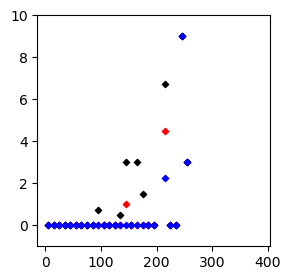

In [276]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(all_lengths, all_num_over_shelf / (all_num_past_break+all_num_over_shelf), s = 1)
# ax.scatter(length_mids, p50_area_shelf_bybin, s=10, c='k', marker='D')
ax.scatter(length_mids, p50_area_break_bybin, s=10, c='r', marker='D')
ax.scatter(length_mids, p75_area_break_bybin, s=10, c='k', marker='D')
ax.scatter(length_mids, p25_area_break_bybin, s=10, c='b', marker='D')

# for xx, dmin, dmax in zip(length_mids, p25_shelf_frac_bybin, p75_shelf_frac_bybin):
#     plt.plot([xx, xx], [dmin, dmax], c='k', lw=0.5, zorder=-1)
    
plt.ylim(-1,10)

(-300.0, 0.0)

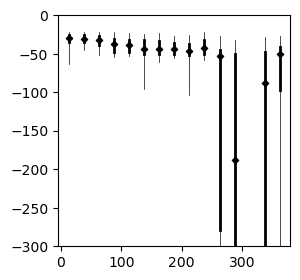

In [261]:
fig, ax = plt.subplots(figsize=(3,3))

plt.scatter(length_mids, p50_depths_bybin, s=10, c='k', marker='D')
# plt.scatter(length_mids, avg_depths_bybin, s=10, c='r', marker='D')

for xx, dmin, dmax in zip(length_mids, p5_depths_bybin, p95_depths_bybin):
    plt.plot([xx, xx], [dmin, dmax], c='k', lw=0.5, zorder=-1)
    
for xx, dmin, dmax in zip(length_mids, p25_depths_bybin, p75_depths_bybin):
    plt.plot([xx, xx], [dmin, dmax], c='k', lw=2, zorder=-1)
    
# plt.scatter(all_lengths, p25_depths, s=1)

# plt.scatter(all_lengths, p75_depths, s=1)

plt.ylim(-300,0)

In [14]:
poly_xx

array([-2209375., -2209375., -2209375., -2215625., -2209375., -2215625.,
       -2215625., -2215625., -2209375.])

In [34]:
RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

sic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)


In [296]:
df.time[df.season_end_flag]

2721    2005-04-29
2722    2005-04-30
4375    2016-04-19
4376    2016-04-20
4377    2016-04-21
4378    2016-04-22
4379    2016-04-23
4380    2016-04-24
4381    2016-04-25
4382    2016-04-26
4383    2016-04-27
4384    2016-04-28
4385    2016-04-29
4386    2016-04-30
4688    2018-04-30
5138    2021-04-26
5139    2021-04-27
5140    2021-04-28
5141    2021-04-29
5142    2021-04-30
Name: time, dtype: object

In [335]:
# open file
years = np.concatenate((np.arange(2003,2012), np.arange(2013,2026)))

open_counts = np.zeros_like(sic['xx'])
total_counts = np.zeros_like(sic['xx'])

open_counts_long = np.zeros_like(sic['xx'])
total_counts_long = np.zeros_like(sic['xx'])

open_counts_short = np.zeros_like(sic['xx'])
total_counts_short = np.zeros_like(sic['xx'])

open_counts_day = np.zeros_like(sic['xx'])
total_counts_day = np.zeros_like(sic['xx'])

LMAX = 120

day = 7

for year in years:

    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.4_radius25km.nc') as DS:

        time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
        DS = DS.sel(time = time_range)

        # find open dates
        open_times = pd.to_datetime(DS.time[DS.extent>0])

        # loop through times
        for ot in open_times:
            
            if ot in pd.to_datetime(df.time[df.season_end_flag].values):
                print('omit', ot)
                
            else:
            
                LENGTH = (6.25+df.length_145max-df.length_145min)[pd.to_datetime(df['time']) == ot].values
                EVENT_DAY = df['event_day'][pd.to_datetime(df['time']) == ot].values

                total_counts+=1

                if LENGTH > LMAX:
                    total_counts_long+=1
                else:
                    total_counts_short+=1
                    
                if EVENT_DAY >= day:
                    total_counts_day+=1

                # extract depths
    #             depth_str = DS.sel(time=ot).depths.values.item()
    #             depths = np.array(depth_str.split("_")[1:]).astype(float)

                # extract max length along 145 coords
        #         max_xx = DS.sel(time=ot).l_max_xx.item()
        #         max_yy = DS.sel(time=ot).l_max_yy.item()

                # extract all coords
                poly_xx_str = DS.sel(time=ot).poly_interior_xx.values.item()
                poly_yy_str = DS.sel(time=ot).poly_interior_yy.values.item()
                poly_xx = np.array(poly_xx_str.split("_")[1:]).astype(float)
                poly_yy = np.array(poly_yy_str.split("_")[1:]).astype(float)

                for xx, yy in zip(poly_xx, poly_yy):

                    loc = np.where((sic['xx']-xx)**2 + (sic['yy']-yy)**2 == 0)
                    open_counts[loc] += 1

                    if LENGTH > LMAX:
                        open_counts_long[loc] += 1
                    else:
                        open_counts_short[loc] += 1
                        
                    if EVENT_DAY >= day:
                        open_counts_day[loc] += 1
                        
                        
freq_all = open_counts/total_counts
freq_long = open_counts_long/total_counts_long
freq_short = open_counts_short/total_counts_short
freq_day = open_counts_day/total_counts_day

omit 2005-04-29 00:00:00
omit 2005-04-30 00:00:00
omit 2016-04-19 00:00:00
omit 2016-04-20 00:00:00
omit 2016-04-21 00:00:00
omit 2016-04-22 00:00:00
omit 2016-04-23 00:00:00
omit 2016-04-24 00:00:00
omit 2016-04-25 00:00:00
omit 2016-04-26 00:00:00
omit 2016-04-27 00:00:00
omit 2016-04-28 00:00:00
omit 2016-04-29 00:00:00
omit 2016-04-30 00:00:00
omit 2018-04-30 00:00:00
omit 2021-04-26 00:00:00
omit 2021-04-27 00:00:00
omit 2021-04-28 00:00:00
omit 2021-04-29 00:00:00
omit 2021-04-30 00:00:00


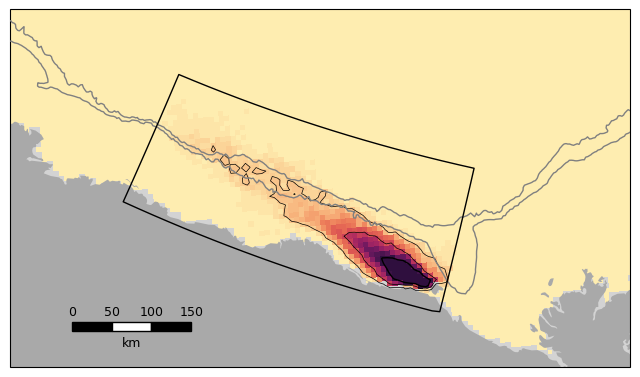

In [336]:
%matplotlib inline
fig, ax = fn.makemap(view='wider_zoom', contours = [-500, -100], figsize=(8,10), panels=(1,1))

# ax.contourf(sic['lon'], sic['lat'], open_counts/total_counts, vmin=0, vmax=0.5, 
#             levels = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#                cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())

ax.pcolormesh(sic['lon'], sic['lat'], freq_day, vmin=0, vmax=0.5, 
               cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())

# ax.pcolormesh(sic['lon'], sic['lat'], open_counts_long/total_counts_long, vmin=0, vmax=0.5, 
#                cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())

# ax.pcolormesh(sic['lon'], sic['lat'], freq_short-freq_all, vmin=-0.5, vmax=0.5, 
#                cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

ax.contour(sic['lon'], sic['lat'], freq_day,
            levels=[0.05,0.25,0.5,], colors=['k'], linewidths = [0.5,0.5,1,1.5], transform=ccrs.PlateCarree())

ax.pcolormesh(sic['lon'], sic['lat'], np.isnan(sic['sic']),
               cmap=matplotlib.colors.ListedColormap(['None', 'lightgray']), 
              transform=ccrs.PlateCarree())

# ax.scatter(all_max_xx, all_max_yy, s = 10, alpha=0.1, transform = sic['proj'])

# plt.ylim(68,72)
# plt.xlim(210,230)

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

geomap.scalebar(ax, loc=(0.1, 0.1), steps=[ 50, 100, 150],unit='km',
                label=None, colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025, 
                labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)



In [313]:
help(geomap.scalebar)

Help on function scalebar in module plot_simply.geomap:

scalebar(ax, loc=(0.1, 0.1), steps=[5, 10, 50], stepsize=50, numsteps=4, unit='km', label=None, colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)
    Add scalebar to to cartopy plot.

    INPUT:
    - ax: cartopy figure axis
    - loc = (x,y) of scalebar's lower left corner, in axes coordinates [0,1] (default: (0.1,0.1))
    - steps: size of each step in scalebar (default: [5,10,50], otherwise None to use stepsize, numsteps)
    - stepsize: distance between scalebar ticks (default: 50, only used if steps is None)
    - numsteps: number of scalebar ticks (default: 4, only used if steps is None)
    - unit: unit of scalebar (default: 'km')
    - label: unit label to display (if None, will use unit) (default: None)
    - colors: list of 2 alternating colors for scalebar ticks (default: ['k','w'])
    - lw: linewidth of scalebar edge (default: 1)
    - b

In [93]:
np.nanpercentile((open_counts/total_counts)[open_counts/total_counts>0], 50)

0.009380863039399626

In [92]:
np.max(open_counts/total_counts)

0.624765478424015

In [25]:
sic['lon']

array([[245.51826, 245.56361, 245.60918, ..., 260.43832, 260.5626 ,
        260.6876 ],
       [245.3972 , 245.44235, 245.48769, ..., 260.2639 , 260.38788,
        260.51263],
       [245.27597, 245.32089, 245.366  , ..., 260.0887 , 260.21243,
        260.3369 ],
       ...,
       [189.94788, 189.88293, 189.81778, ..., 171.85417, 171.72812,
        171.60165],
       [189.85556, 189.79056, 189.72533, ..., 171.76006, 171.63412,
        171.50777],
       [189.76347, 189.69838, 189.63309, ..., 171.66634, 171.54053,
        171.4143 ]], dtype=float32)

In [58]:
ot = datetime(2025,3,11)

DS.sel(time=ot).l_max_xx.item()

-2096875.0

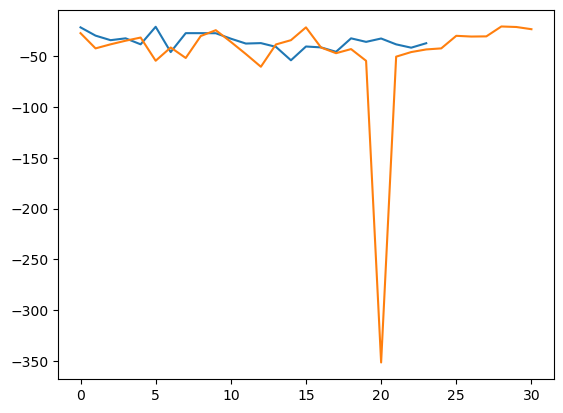

In [7]:
plt.plot(depths_by_year[2017])
plt.plot(depths_by_year[2025])


In [414]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst
dss = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2017_2018_v1.nc')
dss = dss.sel(time=slice(datetime(2016,12,1), datetime(2017,5,1)))
mean_dt = (dss.Ct-dss.Tf).mean('z')
mean_sig = dss.sig0.mean('z')
DT = (dss.Ct-dss.Tf) * units('delta_degC')
SIG = dss.sig0 * units('kg/m3')
U = vectors.comp_along_theta(dss.u, dss.v, 145*units('degree'))* units('m/s')

ht_perm3 = cst['Cp_o']*DT*SIG*U
hc_perm3 = cst['Cp_o']*DT*SIG
dz = dss.z.diff('z').values[0] * units('m')

IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz


ht_perm3 = cst['Cp_o']*DT.mean('time')*SIG.mean('time')*U
IHT_dyn = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz

ht_perm3 = cst['Cp_o']*DT*SIG*U.mean('time')
IHT_therm = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz


IHT_bt = cst['Cp_o']*DT.mean('z')*SIG.mean('z')*U.mean('z') * units('joule/m2/s') * 40
# IHT_bt = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz

ht_perm3 = cst['Cp_o']*(DT-DT.mean('z'))*(SIG-SIG.mean('z'))*(U-U.mean('z'))
IHT_bc = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz

AttributeError: 'Dataset' object has no attribute 'Ct'

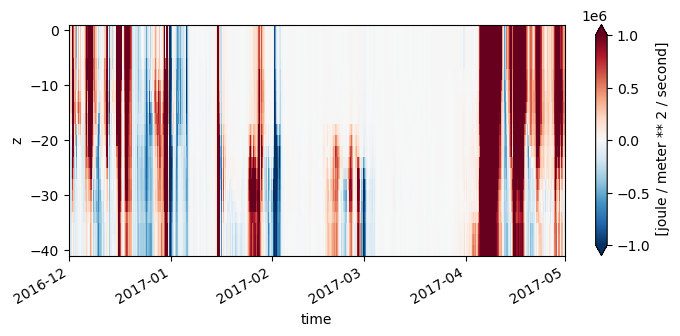

In [413]:
fig, ax = plt.subplots(figsize=(8,3))

(cst['Cp_o'] * SIG * DT * U).plot(vmin=-10e5, vmax=10e5, cmap='RdBu_r')



In [398]:
oht_p = IHT #- np.nanmean(IHT)
oht_nonlinear = oht_p - (IHT_dyn + IHT_therm)

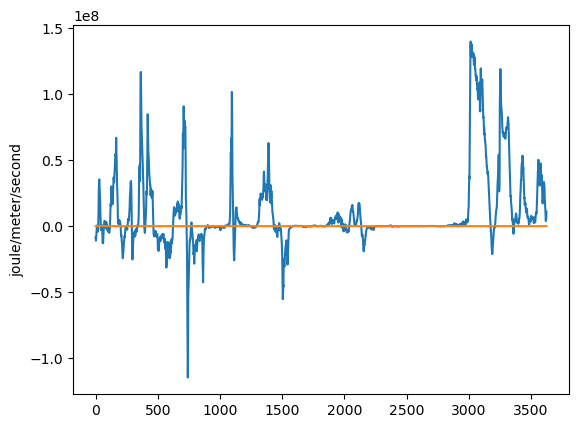

In [405]:
plt.plot(IHT_bt)
plt.plot(IHT_bc)

In [ ]:
DS.sel(time = datetime(2025,3,11)).poly_interior_xx.item()

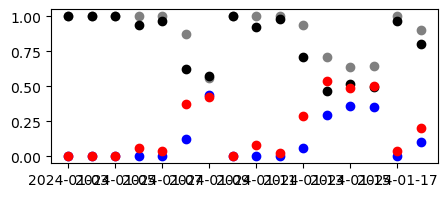

In [50]:
# extract depths
ot = datetime(2025,3,11)

fig, ax = plt.subplots(figsize=(5,2))

for ot in pd.date_range(datetime(2024,1,3),  datetime(2024,1,18)):
    depth_str = DS.sel(time=ot).depths.values.item()
    depths = np.array(depth_str.split("_")[1:]).astype(float)
    
    bordepth_str = DS.sel(time=ot).border_depths.values.item()
    bordepths = np.array(bordepth_str.split("_")[1:]).astype(float)
    
    past_shelfbreak = np.nansum(depths<-100)
    over_shelf = np.nansum(depths>=-100)
    
    bor_past_shelfbreak = np.nansum(bordepths<-100)
    bor_over_shelf = np.nansum(bordepths>=-100)

    
    ax.scatter(ot, (past_shelfbreak)/(past_shelfbreak+over_shelf), c='b')
    ax.scatter(ot, over_shelf/(past_shelfbreak+over_shelf), c='gray')
    
    ax.scatter(ot, bor_over_shelf/(bor_past_shelfbreak+bor_over_shelf), c='k')
    ax.scatter(ot, bor_past_shelfbreak/(bor_past_shelfbreak+bor_over_shelf), c='r')

In [16]:
DS.sel(time = datetime(2025,3,11)).poly_interior_xx.item()

'_-2221875.0_-2215625.0_-2215625.0_-2209375.0_-2215625.0_-2209375.0_-2203125.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2221875.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2221875.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2165625.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2165625.0_-2159375.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2165625.0_-2159375.0_-2153125.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2165625.0_-2159375.0_-2153125.0_-2215625.0_-2209375.0_-2203125.0_-2196875.0_-2190625.0_-2184375.0_-2178125.0_-2171875.0_-2165625.0_-2159375.0_-2153125.0_-2128125.0_-2215625.0_-2209375.0_-2203125.0_-2196875

(array([ 0.,  0.,  2.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  3.,  0.,  0.,  0.,  0.,
         1., 14.,  2.,  8.,  5.,  6., 13., 11.,  2.,  0.,  0.,  0.,  0.]),
 array([-200., -195., -190., -185., -180., -175., -170., -165., -160.,
        -155., -150., -145., -140., -135., -130., -125., -120., -115.,
        -110., -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,
         -65.,  -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,
         -20.,  -15.,  -10.,   -5.]),
 <BarContainer object of 39 artists>)

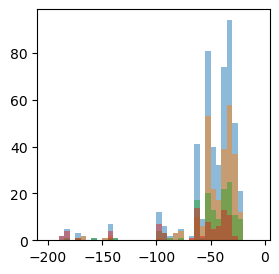

In [12]:
fig, ax = plt.subplots(figsize=(3,3))

# plt.hist(depths_by_year[2019], np.arange(-200,0,5))
plt.hist(all_depths, np.arange(-200,0,5), alpha=0.5)


plt.hist(np.concatenate((depths_by_month[12], 
                         depths_by_month[1])), np.arange(-200,0,5), alpha=0.5)

plt.hist(np.concatenate((depths_by_month[2], 
                         depths_by_month[3])), np.arange(-200,0,5), alpha=0.5)

plt.hist(depths_by_month[4], np.arange(-200,0,5), alpha=0.5)

# plt.hist(depths_by_month[1], np.arange(-200,0,5), alpha=0.5)
# plt.hist(depths_by_month[2], np.arange(-200,0,5), alpha=0.5)
# plt.hist(depths_by_month[3], np.arange(-200,0,5), alpha=0.5)
# plt.hist(depths_by_month[4], np.arange(-200,0,5), alpha=0.5)

In [18]:
ot.month

4

IndexError: boolean index did not match indexed array along dimension 0; dimension is 452 but corresponding boolean dimension is 22

In [17]:
len(all_depths)

452

In [ ]:
plt.hist(all_depths, bins=np.arange(-200,0,5))

In [484]:
time_range = slice(datetime(2019,1,1), datetime(2019,1,22,23))
open_years = '2018_2019'

# time_range = slice(datetime(2017,12,23), datetime(2017,12,27))
# open_years = '2017_2018'

<IPython.core.display.Javascript object>


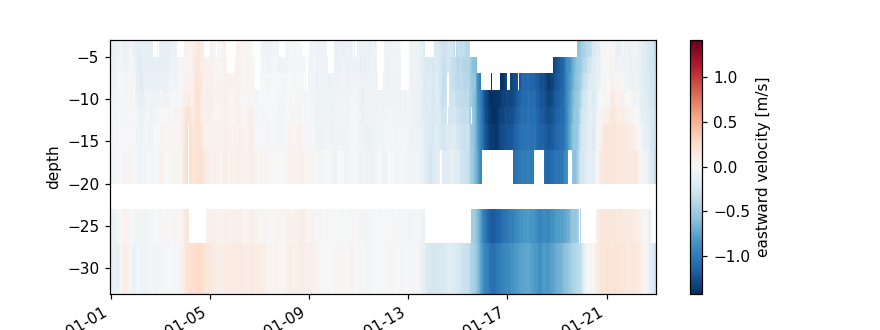

In [485]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc=dsc.sel(time = time_range)

ese_current = vectors.comp_along_theta(dsc.u.mean('depth'), 
                                       dsc.v.mean('depth'), 145*units('degree'))

# ese_current = vectors.comp_along_theta(dsc.u.sel(depth=-10), 
#                                        dsc.v.sel(depth=-10), 145*units('degree'))

%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
dsc.u.plot()

<IPython.core.display.Javascript object>


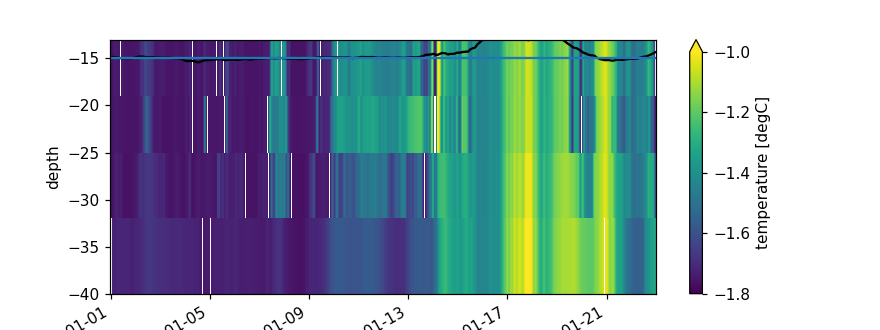

In [487]:
ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
ds = ds.sel(time = dsc.time)


%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
# ds.Sa.plot()

ds.T.plot(vmin=-1.8,vmax=-1)

# ds.sig0.plot()

plt.plot(dsc.time, -2*dsc.u.mean('depth')-15, c='k')
plt.axhline(-15)

In [891]:
DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{open_years.split("_")[-1]}_sic10_v7.nc')
DS = DS.sel(time = slice(dsc.time[0], dsc.time[-1]))

dsw = xr.open_dataset(f'../data/forcing/regional_hourly_era_{open_years.split("_")[-1]}_v7.nc')
dsw = dsw.sel(time = slice(dsc.time[0], dsc.time[-1]))

wind_drift = - 0.03 * dsw.u10 * units('m/s').to('km/hour')

dsw.u10 

<xarray.DataArray 'u10' (time: 264)>
array([-5.066434, -4.878461, -4.676609, ..., -6.950275, -7.496257, -7.888945])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-12 ... 2019-01-22T23:00:00

<IPython.core.display.Javascript object>


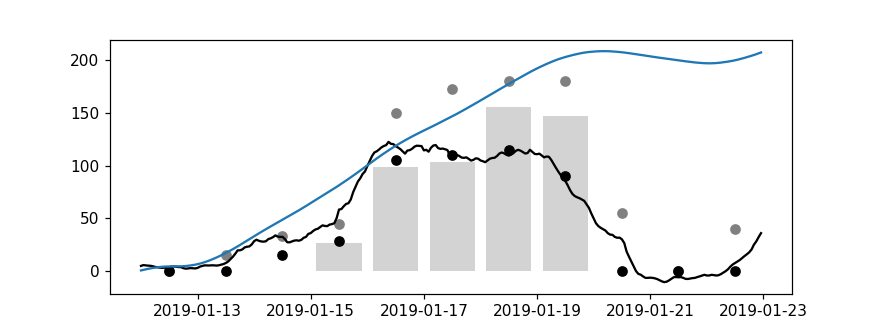

In [897]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dsc.time, ese_current*units('m/s').to('km/day'), c='k')

plt.bar(pd.to_datetime(DS.time) + timedelta(hours=12), DS.l_max, color='lightgray')

plt.plot(dsw.time, np.cumsum(wind_drift))

# plt.scatter(pd.to_datetime(DS.time) + timedelta(hours=12), pack_distance, color='gray')
# plt.scatter(pd.to_datetime(DS.time) + timedelta(hours=12), poly_distance, color='k')

plt.scatter(pd.to_datetime(DS.time) + timedelta(hours=12), pack_ice_dist, color='gray')
plt.scatter(pd.to_datetime(DS.time) + timedelta(hours=12), poly_edg_dist, color='k')



# pack_ice_dist
# plt.plot(pd.to_datetime(dsw.time), -(dsw.u10*dsw.u10*np.sign(dsw.u10)))

In [308]:
DS.time

<xarray.DataArray 'time' (time: 11)>
array(['2019-01-12T00:00:00.000000000', '2019-01-13T00:00:00.000000000',
       '2019-01-14T00:00:00.000000000', '2019-01-15T00:00:00.000000000',
       '2019-01-16T00:00:00.000000000', '2019-01-17T00:00:00.000000000',
       '2019-01-18T00:00:00.000000000', '2019-01-19T00:00:00.000000000',
       '2019-01-20T00:00:00.000000000', '2019-01-21T00:00:00.000000000',
       '2019-01-22T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-01-12 2019-01-13 ... 2019-01-22

In [419]:
from pyproj import Geod
g = Geod(ellps='WGS84')

HI_lon = -139.1
HI_lat = 69.6
linelon, linelat, backaz = g.fwd(HI_lon, HI_lat, 
                               90-145, 1000*200)

endlon, endlat, backaz = g.fwd(HI_lon, HI_lat, 
                               90-145, 1000*50)

endlon, endlat

(-140.1651629682272, 69.85387367778951)

In [309]:
pack_distance = np.array([0, 10, 30, 45, 150, 170, 185, 185, 50, 0, 0])
poly_distance = np.array([0, 0,  15, 25, 110, 120, 125, 90, 0, 0, 0])

In [479]:

date = datetime(2017,12,25)

date = datetime(2019,1, 19)
RES = '3125'
crop=[1500, 2050, 480, 700]
sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

In [501]:
# transect along polynya

dist = 500 # km
step_size = 5 # km
npts = dist/step_size

distances = np.arange(0, dist, step_size)

del_s = 1000*dist/(npts+1)
r = g.fwd_intermediate(HI_lon,HI_lat,90-145,npts=npts,del_s=del_s)
tr_lons = np.array([])
tr_lats = np.array([])
for lon,lat in zip(r.lons, r.lats): 
    tr_lons = np.append(tr_lons, lon)
    tr_lats = np.append(tr_lats, lat)
    
out = sic['proj'].transform_points(ccrs.PlateCarree(), tr_lons, tr_lats)
trans_x, trans_y = out[:,0], out[:,1]



# transect against polynya
dist = 200 # km
step_size = 5 # km
npts = dist/step_size

distances = np.arange(0, dist, step_size)

del_s = 1000*dist/(npts+1)
r = g.fwd_intermediate(HI_lon,HI_lat,90-(145-90),npts=npts,del_s=del_s)
tr_lons = np.array([])
tr_lats = np.array([])
for lon,lat in zip(r.lons, r.lats): 
    tr_lons = np.append(tr_lons, lon)
    tr_lats = np.append(tr_lats, lat)
    
out = sic['proj'].transform_points(ccrs.PlateCarree(), tr_lons, tr_lats)
transp_x, transp_y = out[:,0], out[:,1]


# transect against polynya
dist = 200 # km
step_size = 5 # km
npts = dist/step_size

distances = np.arange(0, dist, step_size)

del_s = 1000*dist/(npts+1)
r = g.fwd_intermediate(HI_lon,HI_lat,90-(145+90),npts=npts,del_s=del_s)
tr_lons = np.array([])
tr_lats = np.array([])
for lon,lat in zip(r.lons, r.lats): 
    tr_lons = np.append(tr_lons, lon)
    tr_lats = np.append(tr_lats, lat)
    
out = sic['proj'].transform_points(ccrs.PlateCarree(), tr_lons, tr_lats)
transp_x = np.append(transp_x, out[:,0][::-1][:-1])
transp_y = np.append(transp_y, out[:,1][::-1][:-1])


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pyproj/geod.py:829: UserWarning: Back azimuth is being returned by default to be compatible with inv()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pyproj/geod.py:829: UserWarning: Back azimuth is being returned by default to be compatible with inv()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pyproj/geod.py:829: UserWarning: Back azimuth is being returned by default to be compatible with inv()This is a breaking change for pyproj 3.5+.To avoid this warnin

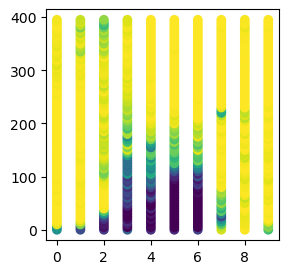

In [464]:
# daily_dates = pd.to_datetime(DS.time.values)

# daily_dates = pd.date_range(datetime(2017,12,22), datetime(2017,12,27))

daily_dates = pd.date_range(datetime(2019,1,13), datetime(2019,1,22))

fig, ax = plt.subplots(figsize=(3,3))

for dd, date in enumerate(daily_dates):
    RES = '3125'
    crop=[1500, 2050, 480, 700]
    sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                crop=crop, coordinates=False, area=False, 
                                include_units=False, quiet=True)
    
    tr_sic = np.array([])
    for tr_x, tr_y in zip(trans_x, trans_y):
        dist = (sic['xx'] - tr_x)**2 + (sic['yy'] - tr_y)**2 
        nearest_sic = sic['sic'][np.where(dist == dist.min())]
        tr_sic = np.append(tr_sic, nearest_sic)
        
    plt.scatter(np.full(len(distances), dd), distances, c = tr_sic, vmin=0, vmax=100)

In [502]:
axis_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axis_dist)[0]):
    for jj in range(np.shape(axis_dist)[1]):
        
        dx = sic['xx'][ii,jj] - transp_x
        dy = sic['yy'][ii,jj] - transp_y
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] > 0):
            sign = 1
            
        axis_dist[ii,jj] = sign * np.min(dist2)

axis_dist = axis_dist / 1000 # km


axisP_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axisP_dist)[0]):
    for jj in range(np.shape(axisP_dist)[1]):
        
        dx = sic['xx'][ii,jj] - trans_x
        dy = sic['yy'][ii,jj] - trans_y
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        axisP_dist[ii,jj] = np.min(dist2)

axisP_dist = axisP_dist / 1000 # km



In [539]:
bin_dists = np.arange(0,405,5)
bin_centers = bin_dists[:-1] + np.diff(bin_dists)[0]/2

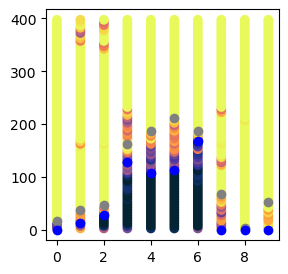

In [578]:
fig, ax = plt.subplots(figsize=(3,3))



for dd, date in enumerate(daily_dates):
    RES = '3125'
    crop=[1500, 2050, 480, 700]
    sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                crop=crop, coordinates=False, area=False, 
                                include_units=False, quiet=True)
    

    transect_sic_mean = np.array([])
    transect_sic_min = np.array([])
    for bb in range(len(bin_dists)-1):
        
        within_distance = (axis_dist >= bin_dists[bb]) & (axis_dist < bin_dists[bb+1])
        sic_within_range = sic['sic'][(within_distance) & (axisP_dist < 25)]
        
        transect_sic_mean = np.append(transect_sic_mean, np.nanmean(sic_within_range))
        transect_sic_min = np.append(transect_sic_min, np.nanmin(sic_within_range))
        
#     plt.scatter(np.full(len(bin_centers), dd), bin_centers, c = transect_sic_min, 
#                 vmin=0, vmax=100, cmap=cmocean.cm.thermal)

    plt.scatter(np.full(len(bin_centers), dd), bin_centers, c = transect_sic_min, 
                vmin=0, vmax=70, cmap=cmocean.cm.thermal)

    
    # define edge of pack ice
#     pack_dist = bin_centers[transect_sic_mean >=70].min()
    
#     ax.scatter(dd, pack_dist)

    pol_edge = np.where(transect_sic_min < 10)[0]
    if len(pol_edge) == 0:
        pol_edge_dist = 0
    else:
        pol_edge_dist = bin_centers[pol_edge][-1]
    
    not_consol = np.where(transect_sic_min > 70)[0]
    
    if len(not_consol) == 0:
        pack_dist_2 = 0
    else:   
#         pack_dist_2 = bin_centers[not_consol[::-1][0]]

        pack_dist_2 = bin_centers[not_consol[0]]
    
    ax.scatter(dd, pack_dist_2, c='gray')
    ax.scatter(dd, pol_edge_dist, c='b')
    
    

In [637]:
date = datetime(2019,1,19)

# date = datetime(2017,12,25)

RES = '3125'
crop=[1500, 2050, 480, 700]
sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

In [645]:
zone = (axisP_dist < 10) & (axis_dist > 0)

open_water = (sic['sic']<=10)
new_ice = (sic['sic']>10) & (sic['sic']<70)
pack_ice = (sic['sic']>=70)
                       

In [646]:
np.nanpercentile(axis_dist[open_water & zone], 90)
np.nanpercentile(axis_dist[new_ice & zone], 90)

145.67820982450522

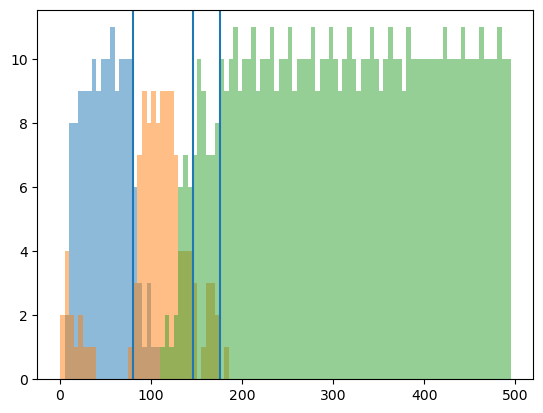

In [647]:
plt.hist(axis_dist[open_water & zone],bins=np.arange(0,500,5), alpha=0.5);
plt.hist(axis_dist[new_ice & zone],bins=np.arange(0,500,5), alpha=0.5);
plt.hist(axis_dist[pack_ice & zone],bins=np.arange(0,500,5), alpha=0.5);

plt.axvline(np.nanpercentile(axis_dist[open_water & zone], 90))
plt.axvline(np.nanpercentile(axis_dist[new_ice & zone], 90))
plt.axvline(np.nanpercentile(axis_dist[pack_ice & zone], 10))

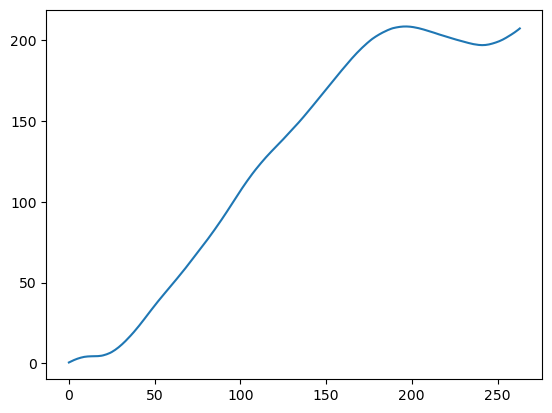

In [648]:
plt.plot(np.cumsum(wind_drift))

In [898]:
date = datetime(2019,1,22)
sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

In [899]:
pack_ice_dist = [0, 15, 33, 45, 150, 173, 180, 180, 55, 0, 40]
poly_edg_dist = [0,  0, 15, 28, 105, 110, 115, 90, 0, 0, 0]

<IPython.core.display.Javascript object>


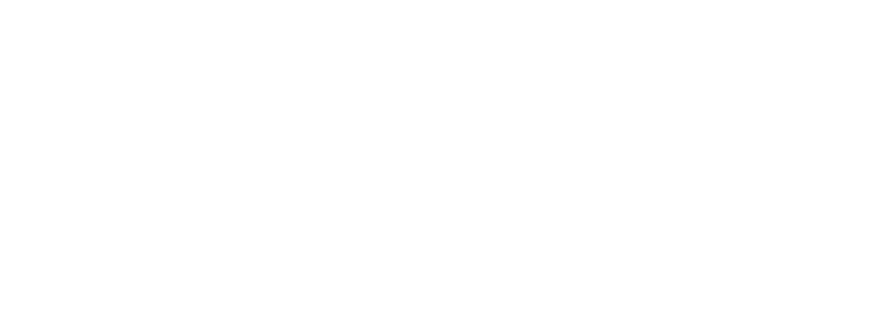

<IPython.core.display.Javascript object>


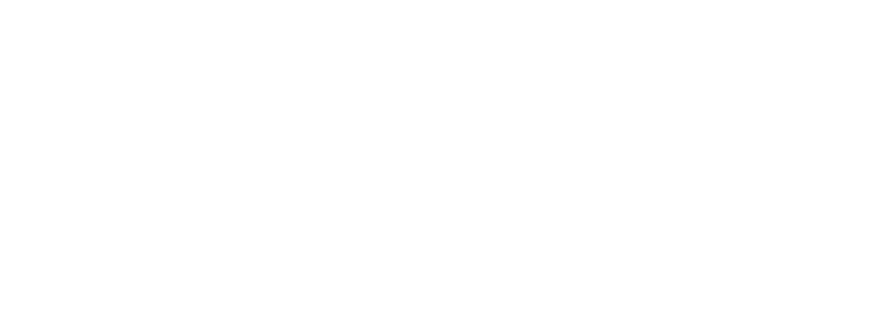

<IPython.core.display.Javascript object>


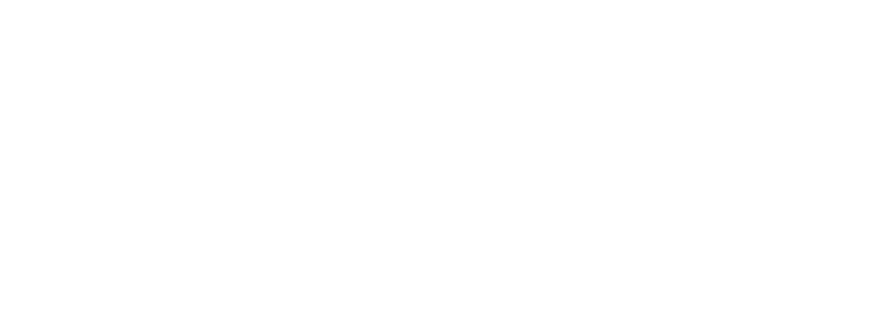

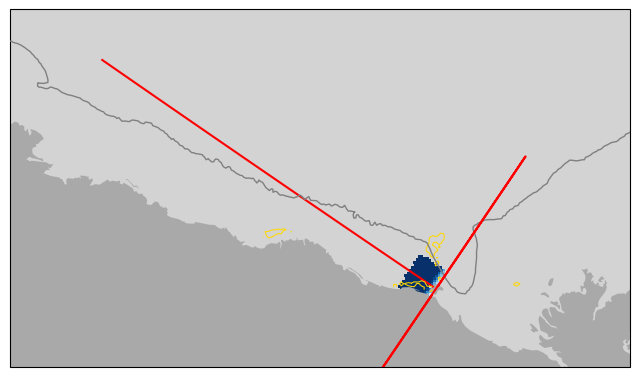

In [900]:
%matplotlib inline
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

ignore = (axisP_dist > 25) 
ignore[(axis_dist < 0)] = True
ignore[axis_dist>40] = True
ax.pcolormesh(sic['xx'], sic['yy'], ma.masked_where(ignore, axis_dist), 
              vmin=0, vmax=10, cmap='Blues', 
              transform=sic['proj'])


ax.plot(trans_x, trans_y, c='r', transform=sic['proj'])
ax.plot(transp_x, transp_y, c='r', transform=sic['proj'], zorder=100)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['r', 'gold'], linewidths=0.75)



In [643]:
tr_sic = np.array([])
for tr_x, tr_y in zip(tr_xx, tr_yy):
    dist = (sic['xx'] - tr_x)**2 + (sic['yy'] - tr_y)**2 
    nearest_sic = sic['sic'][np.where(dist == dist.min())]
    tr_sic = np.append(tr_sic, nearest_sic)
    

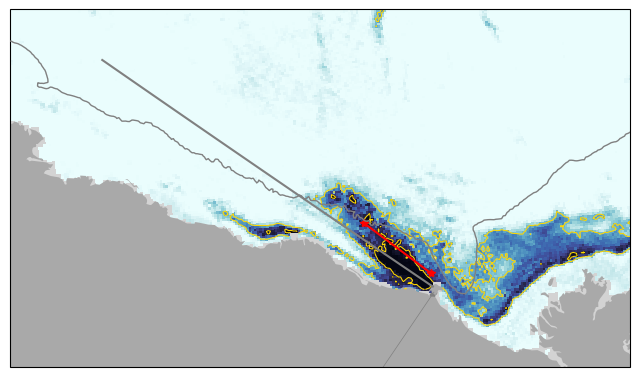

In [903]:
%matplotlib inline
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)



# ax.plot([HI_lon,linelon], [HI_lat,linelat], c='gray', lw=0.5, transform=ccrs.PlateCarree())


ax.plot(tr_lons, tr_lats, c='gray', lw=0.5, transform=ccrs.PlateCarree())
ax.scatter(tr_lons, tr_lats, c='gray',  s=10, transform=ccrs.PlateCarree())

# ax.plot([HI_lon, endlon], [HI_lat, endlat],c='r', transform=ccrs.PlateCarree())


ax.plot(trans_x, trans_y, c='gray', transform=sic['proj'])

ax.plot([m1_lon, endlon],
        [m1_lat, endlat], c='r',  transform=ccrs.PlateCarree(), marker='*')



In [901]:
date = datetime(2019,1,19)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

In [902]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc=dsc.sel(time = slice(date, date+timedelta(hours=12)))

ese_current = vectors.comp_along_theta(dsc.u.mean('depth').mean('time'), 
                                       dsc.v.mean('depth').mean('time'), 145*units('degree'))

current_angle = vectors.vector_angle(dsc.u.mean('depth').mean('time').values, 
                                     dsc.v.mean('depth').mean('time').values)


# current_speed = np.sqrt(dsc.u.mean('depth')**2+dsc.v.mean('depth')**2).mean('time').values.item()
current_speed = np.sqrt(dsc.u.mean('depth').mean('time')**2+dsc.v.mean('depth').mean('time')**2).values.item()
flow_dist = current_speed * units('m/s').to('km/day').magnitude


m1_lon = dsc.attrs['lon']
m1_lat = dsc.attrs['lat']

m1_loc = (m1_lon, m1_lat)
HI_loc = (HI_lon, HI_lat)

endlon, endlat, backaz = g.fwd(*m1_loc, 90-(current_angle.magnitude), 1000*flow_dist)



In [ ]:
ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_{open_years}_v0.nc')
ds.close()

mean_dt = ds.dT.mean('z')
mean_sig = ds.sig0.mean('z')
DT = ds.dT * units('delta_degC')
SIG = ds.sig0 * units('kg/m3')
U = vectors.comp_along_theta(ds.u, ds.v, 145*units('degree'))* units('m/s')

ht_perm3 = cst['Cp_o']*DT*SIG*U
hc_perm3 = cst['Cp_o']*DT*SIG
dz = ds.z.diff('z').values[0] * units('m')

IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

hc_event = hc_perm3.sel(time=time_range)
IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz



In [444]:
df = pd.read_csv('../data/compiled_stats.csv')

# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]


#===============
DF = dfr
#===============

In [477]:
si = DF.index[DF.sequence==157][0]-1
fi = DF.index[DF.sequence==157][-1]

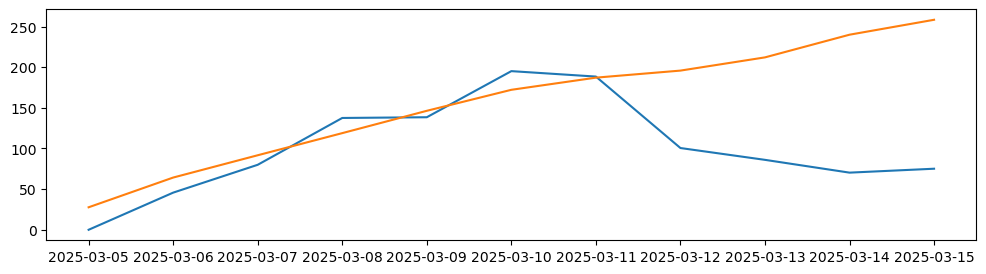

In [479]:
fig, ax= plt.subplots(figsize=(12,3))
plt.plot(DF.loc[si:fi].time, DF.loc[si:fi].length_145)
plt.plot(DF.loc[si:fi].time, np.cumsum(-0.03*DF.loc[si:fi].u10*units('m/s').to('km/day')))

In [202]:
shoulder = (df.season_start_flag == True) + (df.season_end_flag == True)

In [203]:
# seqs = list(set(df.sequence.values[df.sequence.values!=-999]))

seqs = list(set(df.sequence.values[(df.sequence.values!=-999) & (shoulder==False)]))

85
116
132
147
157


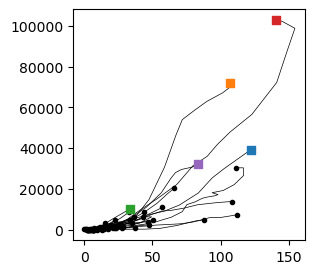

In [205]:
# %matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

for ss in seqs:
    
#     iu = df[df.sequence == ss].ui.values
#     iv = df[df.sequence == ss].vi.values
#     ese = vectors.comp_along_theta(iu, iv, 145*units('degree'))
    
    
    
    wu = df[df.sequence == ss].u10.values
    wv = df[df.sequence == ss].v10.values
    wsp = np.sqrt(wu**2+wv**2)
    
    sew = vectors.comp_along_theta(wu, wv, 145*units('degree'))
    
    wa = vectors.vector_angle(wu, wv).magnitude
    within_range = (wa > 155) + (wa < -175)
    wsp_range = np.copy(wsp)
    wsp_range[within_range==False] = 0
    
    
    wsu = wu*wu*np.sign(wu)
    wsv = wv*wv*np.sign(wv)
    
    ws = np.sqrt(wsu**2+wsv**2)
    
    wsese = vectors.comp_along_theta(wsu, wsv, 145*units('degree'))

    lengths = df[df.sequence == ss].length_max.values
    widths = df[df.sequence == ss].width595.values
    extents = df[df.sequence == ss].extent.values
    
#     y = np.cumsum(lengths)
#     plt.plot(np.cumsum(wsu), np.cumsum(extents), marker='.')
#     plt.plot(np.cumsum(ws), np.cumsum(extents), marker='.')


#     wind_drift = -0.02 * wu * units('m/s').to('km/day').magnitude
#     x = np.cumsum(-wu) + np.cumsum(wv)

    x = np.cumsum(sew)
    y = np.cumsum(extents)
        
    if pd.to_datetime(df.time[df.sequence.values == ss].values[0]).year >= 2016:

        plt.plot(x, y, c = 'k', lw=0.5)
        
        plt.scatter(x[-1], y[-1], marker='.', c='k')

        if ss in [85, 116, 132, 147, 157]:
            print(ss)
            plt.scatter(x[-1], y[-1], marker='s', zorder=100)


#     if pd.to_datetime(df.time[df.sequence.values == ss].values[0]).year >= 2016:

#     plt.plot(np.cumsum(wsu), np.cumsum(wsv), c = 'k', lw=0.5)
#     plt.scatter(np.cumsum(wsu), np.cumsum(wsv), c = y, lw=0.5, vmin=0, vmax=100000)

#     plt.scatter(x[-1], y[-1], marker='.', c='k')

#     if ss in [85, 116, 132, 147, 157]:
#         print(ss)
#         plt.scatter(x[-1], y[-1], marker='s', zorder=100)

        
#     if x[-1] > 90:
#         print(ss)
# plt.ylim(-5000,120000)
# plt.xlim(-50,200)

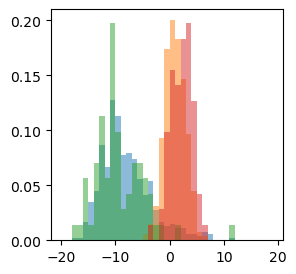

In [206]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(df.u10[df.extent>0], bins=np.arange(-20,20,1), alpha=0.5, density=True);
plt.hist(df.v10[df.extent>0], bins=np.arange(-20,20,1), alpha=0.5, density=True);


plt.hist(df.u10[df.extent>3000], bins=np.arange(-20,20,1), alpha=0.5, density=True);
plt.hist(df.v10[df.extent>3000], bins=np.arange(-20,20,1), alpha=0.5, density=True);

In [305]:
df.extent[df.sequence == 132]

5231    2028.583316
5232    3396.338300
5233    3318.699804
5234    1659.349902
Name: extent, dtype: float64

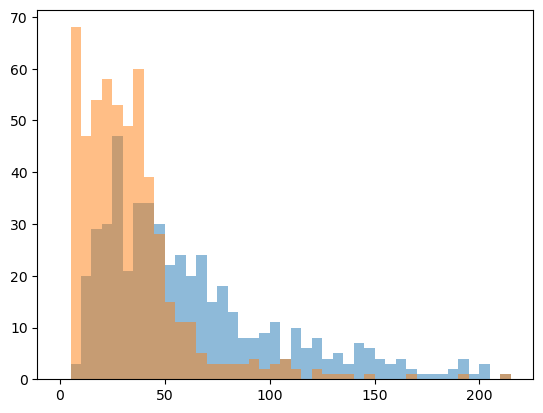

In [254]:
plt.hist(3.125+df.length[np.isfinite(df.length)], bins=np.arange(0,220,5), alpha=0.5);
plt.hist(6.25+df.width[np.isfinite(df.width)], bins=np.arange(0,220,5), alpha=0.5);

In [18]:
plt.scatter(df[df.sequence == ss].u10, df[df.sequence == ss].length)

5731   -12.07154
Name: u10, dtype: float64

In [234]:
df[df.sequence == 85].time

4361    2016-04-05
4362    2016-04-06
4363    2016-04-07
4364    2016-04-08
4365    2016-04-09
4366    2016-04-10
4367    2016-04-11
4368    2016-04-12
4369    2016-04-13
4370    2016-04-14
4371    2016-04-15
4372    2016-04-16
Name: time, dtype: object

NameError: name 'dsc' is not defined

In [428]:
# all_new_lengthsv1  = np.array([])
# all_new_lengthsv2  = np.array([])
# all_length_directionsv1  = np.array([])
# all_length_directionsv2  = np.array([])
# all_original_lengths  = np.array([])
# all_times  = np.array([], dtype=np.datetime64)

# # look_years = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2013,
# #               2014,2015,2016,2017, 2018, 2019,2020, 2021,2022,2023,2024,2025]

# look_years = [2020,2021]

# for year in look_years:

#     with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc') as ds:
        
#         time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
#         ds = ds.sel(time = time_range)
        
#         non_nan = ds.polynya_extent > 0
        
#         all_new_lengthsv1 = np.append(all_new_lengths, ds.max_length.values[non_nan])
#         all_times = np.append(all_times, ds.time.values[non_nan])
#         all_length_directionsv1 = np.append(all_length_directionsv1, ds.max_length_direction.values[non_nan])
#         all_original_lengths = np.append(all_original_lengths, ds.l_max.values[non_nan])
        
#     with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.2_radius25km.nc') as ds:
        
        
        
#         time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
#         ds = ds.sel(time = time_range)
        
#         non_nan = ds.polynya_extent > 0
        
#         all_new_lengthsv2 = np.append(all_new_lengths, ds.max_length.values[non_nan])
# #         all_times = np.append(all_times, ds.time.values[non_nan])
#         all_length_directionsv2 = np.append(all_length_directionsv2, ds.max_length_direction.values[non_nan])
# #         all_original_lengths = np.append(all_original_lengths, ds.l_max.values[non_nan])
        
# all_new_lengths = all_new_lengths[np.isfinite(all_new_lengths)]
# all_length_directions = all_length_directions[np.isfinite(all_length_directions)]
# all_original_lengths = all_original_lengths[np.isfinite(all_original_lengths)]
# all_times = pd.to_datetime(all_times)

# year_cond = np.array([True if YEAR in look_years else False for YEAR in df.year])
# COND = np.array([True if date in all_times else False for date in pd.to_datetime(df.time)])


DF = dfb

COND = (DF.extent > 0) & (DF.final_day==False)
 
uw, vw = (DF.u10.values[COND], DF.v10.values[COND])
wind_angles = vectors.vector_angle(uw, vw).magnitude

ui, vi = (DF.ui.values[COND], DF.vi.values[COND])
pack_ice_angles = vectors.vector_angle(ui, vi).magnitude

wind_angles[wind_angles<0]+=360
pack_ice_angles[pack_ice_angles<0]+=360


# poly_angles = DF.max_length_direction.values[COND]
poly_angles = DF.centermass_direction.values[COND]

# polynya orientation as a vector
up = np.cos(poly_angles*np.pi/180)
vp = np.sin(poly_angles*np.pi/180)

In [424]:
COND2 = np.where(DF.extent > 0)[0]-1
uw, vw = (DF.u10.values[COND2], DF.v10.values[COND2])
wind_angles = vectors.vector_angle(uw, vw).magnitude
wind_angles[wind_angles<0]+=360

before: -3
before: -2
before: -1
during: 1
during: 2
during: 3
during: 4
during: 5
during: 6
during: 7
during: 8
during: 9
final day: 10
after: 11 1
after: 12 2
after: 13 3


(100.0, 270.0)

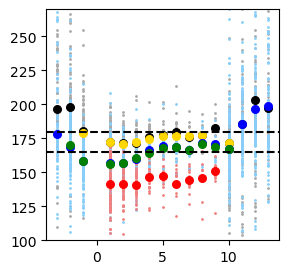

In [388]:

fig, ax = plt.subplots(figsize=(3,3))

days_before = 3
L_max = 10
days_after = 3

db = np.arange(-days_before, 0)
do = np.arange(1, L_max)
df = np.array([L_max])
da = np.arange(L_max+1, L_max+1+days_after)

all_dd = np.concatenate((db, do, df, da))


for dd in all_dd:
    
    if dd in db:
        COND = (DF.day_before_event == dd)
        print('before:', dd)
    elif dd in do:
        if dd == 1:
            COND = (DF.event_day == 1)
        else:
            COND = (DF.event_day == dd) & (DF.final_day==False)
        print('during:', dd)
    elif dd in df:
        COND = (DF.final_day==True)
        print('final day:', dd)
    elif dd in da:
        COND = (DF.day_after_event == dd - (L_max))
        print('after:', dd,  dd - (L_max))
    
    uw, vw = (DF.u10.values[COND], DF.v10.values[COND])
    wind_speeds = np.sqrt(uw**2 + vw**2)
    wind_angles = vectors.vector_angle(uw, vw).magnitude
    wind_angles[wind_angles<0]+=360
    angle_avg_wind = vectors.vector_angle(np.nanmean(uw), np.nanmean(vw)).magnitude
    
    ui, vi = (DF.ui.values[COND], DF.vi.values[COND])
    pack_ice_speeds = np.sqrt(ui**2 + vi**2)
    pack_ice_angles = vectors.vector_angle(ui, vi).magnitude
    pack_ice_angles[pack_ice_angles<0]+=360
    angle_avg_pack_ice = vectors.vector_angle(np.nanmean(ui), np.nanmean(vi)).magnitude

    # polynya orientation as a vector
    poly_angles = DF.centermass_direction.values[COND]
    up = np.cos(poly_angles*np.pi/180)
    vp = np.sin(poly_angles*np.pi/180)
    
    twp = vectors.turning_angle((uw,vw), (up,vp))
    twi = vectors.turning_angle((uw,vw), (ui,vi))
    tip = vectors.turning_angle((ui,vi), (up,vp))
    
    

    
#     wf = (pack_ice_speeds/wind_speeds)[wind_speeds>3]
#     ax.scatter(np.full(len(wf), dd), wf, s=1)
#     ax.scatter(dd, np.nanmedian(wf), s=30, c='k')
    
    
#     plt.scatter(np.full(len(twi), dd), twi, s=1, c='darkgray')
#     plt.scatter(dd, np.nanmedian(twi), s=30, c='k')
    
    
    
    plt.scatter(np.full(len(wind_angles), dd), wind_angles, s=1, c='darkgray', zorder=-1)
    plt.scatter(dd, np.nanmedian(wind_angles), s=30, c='k')
    plt.scatter(dd, angle_avg_wind, s=30, c='gold')
    
    plt.scatter(np.full(len(pack_ice_angles), dd), pack_ice_angles, s=1, c='lightskyblue', zorder=-1)
    plt.scatter(dd, np.nanmedian(pack_ice_angles), s=30, c='b')
    plt.scatter(dd, angle_avg_pack_ice, s=30, c='green')
    
    if dd in do:
        plt.scatter(np.full(len(poly_angles), dd), poly_angles, s=1, c='lightcoral', zorder=-1)
        plt.scatter(dd, np.nanmedian(poly_angles), s=30, c='r')
    
plt.axhline(165, c='k', ls='dashed')
plt.axhline(180, c='k', ls='dashed')

plt.ylim(100,270)

# plt.axhline(13, c='k', ls='dashed')
# plt.axhline(28, c='b', ls='dashed')

In [429]:
twp = vectors.turning_angle((uw,vw), (up,vp))
twi = vectors.turning_angle((uw,vw), (ui,vi))
tip = vectors.turning_angle((ui,vi), (up,vp))

print(np.nanmedian(twi))
print(np.nanmedian(twp))
print(np.nanmedian(tip))

14.100414516729534 degree
28.465152233041522 degree
16.22514805267207 degree


In [267]:
180 - 13.33

166.67

In [268]:
180 - 25

155

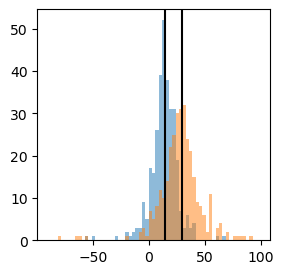

In [435]:
fig, ax = plt.subplots(figsize=(3,3));

# ax.scatter(all_original_lengths, all_new_lengths)

ax.hist(twi, bins=np.arange(-90,100,3), alpha=0.5);
# ax.hist(tip, bins=np.arange(-90,100,5), alpha=0.5);
ax.hist(twp, bins=np.arange(-90,100,3), alpha=0.5);
# ax.hist(twp, bins=np.arange(-180,180,10), alpha=0.5);
plt.axvline(15, c='k')
plt.axvline(30, c='k')


In [436]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145', 'length_max',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length',
       'before_event_length'],
      dtype='object')

In [398]:
np.nanmedian(poly_angles)

142.76785249427724

In [421]:
len(DF.length_145[COND])

330

In [422]:
len(wind_angles[1:])

473

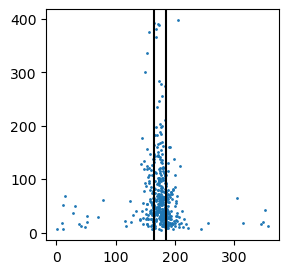

In [426]:
fig, ax = plt.subplots(figsize=(3,3));

plt.scatter(wind_angles[1:], DF.length_145[COND].values[1:], s=1)

plt.axvline(185, c='k')
plt.axvline(165, c='k')

In [402]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145', 'length_max',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length',
       'before_event_length'],
      dtype='object')

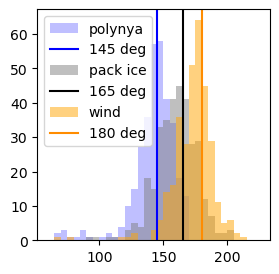

In [443]:
fig, ax = plt.subplots(figsize=(3,3));

# ax.scatter(all_original_lengths, all_new_lengths)

ax.hist(poly_angles, bins=np.arange(60,230,5), color='blue', alpha=0.25, label='polynya');
plt.axvline(145, c='b', label='145 deg')
ax.hist(pack_ice_angles, bins=np.arange(60,230,5), color='gray', alpha=0.5, label='pack ice');
plt.axvline(165, c='k', label='165 deg')
ax.hist(wind_angles, bins=np.arange(60,230,5), color='orange', alpha=0.5, label='wind');
plt.axvline(180, c='darkorange', label='180 deg')

plt.legend()
# ax.hist(all_new_lengths, bins=np.arange(0,445,15));
# # ax.hist(all_original_lengths, bins=np.arange(0,445,15));
# plt.axvline(145, c='k')


In [397]:
np.arange(60+2.5,230,5) + 2.5

array([ 65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.,
       175., 180., 185., 190., 195., 200., 205., 210., 215., 220., 225.,
       230.])

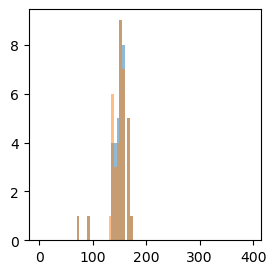

In [1118]:
fig, ax = plt.subplots(figsize=(3,3));

# ax.scatter(all_original_lengths, all_new_lengths)

ax.hist(all_length_directionsv1, bins=np.arange(0,400,5), alpha=0.5);
ax.hist(all_length_directionsv2, bins=np.arange(0,400,5), alpha=0.5);




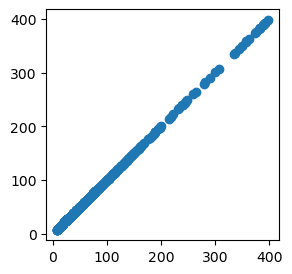

In [1110]:
fig, ax = plt.subplots(figsize=(3,3));

plt.scatter(all_new_lengthsv1, all_new_lengthsv2)

<BarContainer object of 45 artists>

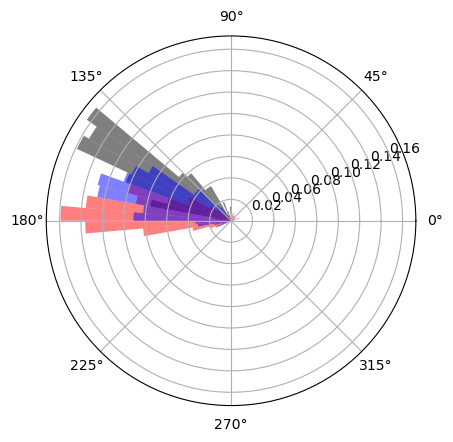

In [920]:
ax = plt.subplot(projection='polar')
ax.set_theta_zero_location('E')

bins = np.arange(0,230,5)
hw = plotter.quick_hist(all_length_directions, bin_edges = bins)

theta = hw['centers']*np.pi/180
radii = hw['prob']
width = hw['w']*np.pi/180
ax.bar(theta, radii, width=width, bottom=0.0, color='k', alpha=0.5)


hw = plotter.quick_hist(wind_angles, bin_edges = bins)

theta = hw['centers']*np.pi/180
radii = hw['prob']
width = hw['w']*np.pi/180
ax.bar(theta, radii, width=width, bottom=0.0, color='r', alpha=0.5)


hw = plotter.quick_hist(pack_ice_angles, bin_edges = bins)

theta = hw['centers']*np.pi/180
radii = hw['prob']
width = hw['w']*np.pi/180
ax.bar(theta, radii, width=width, bottom=0.0, color='blue', alpha=0.5)

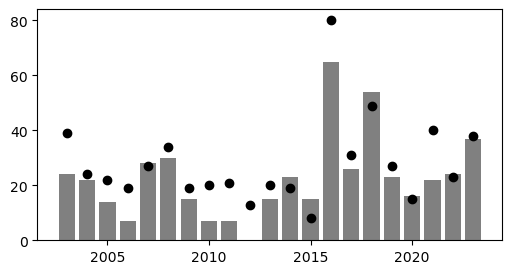

In [1173]:
fig, ax = plt.subplots(figsize=(6,3))

years = np.arange(2003,2024)

for yy, year in enumerate(years):
    
    time_cond = (df.year==year) #& (df.month==3) 
    cond = (df.extent > 0) & time_cond
    
    u10 = df.u10[time_cond].values
    v10 = df.v10[time_cond].values
    s10 = np.sqrt(u10**2 + v10**2)
    
    U10 = df.u10[cond].values
    V10 = df.v10[cond].values
    S10 = np.sqrt(U10**2 + V10**2)
    
    
    Ui = df.ui[cond].values
    Vi = df.vi[cond].values
    Si = np.sqrt(Ui**2 + Vi**2)
    
    ui = df.ui[time_cond].values
    vi = df.vi[time_cond].values
    si = np.sqrt(ui**2 + vi**2)
    
#     ax.scatter(year, np.nanmedian(s10), c='gray')

    plt.bar(year, np.sum(cond), color='gray')
    ax.scatter(year, np.sum(si > 15), c='k')

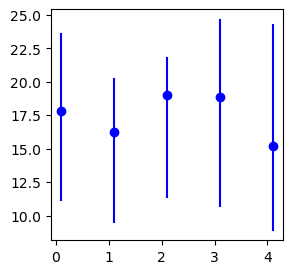

In [1080]:

fig, ax = plt.subplots(figsize=(3,3))

months = [12,1,2,3,4]



for mm, month in enumerate(months):

    
    time_cond = (df.month==month) & ((df.year <= 2023) & (df.year >= 2003))
    
#     cond = ((df.extent > 0) & (df.month==month)) & (df.year <= 2023)

#     cond = (df.extent > 0) & time_cond


    wind_dirs = vectors.vector_angle(df.u10.values, df.v10.values).magnitude
    
    
#     cond = ((wind_dirs < -155) + (wind_dirs>170)) & time_cond


    cond = (df.extent > 0) & time_cond
    
    u10 = df.u10[time_cond].values
    v10 = df.v10[time_cond].values
    s10 = np.sqrt(u10**2 + v10**2)
    
    U10 = df.u10[cond].values
    V10 = df.v10[cond].values
    S10 = np.sqrt(U10**2 + V10**2)
    
    
    Ui = df.ui[cond].values
    Vi = df.vi[cond].values
    Si = np.sqrt(Ui**2 + Vi**2)
    
    ui = df.ui[time_cond].values
    vi = df.vi[time_cond].values
    si = np.sqrt(ui**2 + vi**2)
    
    wf = si/s10
    
    WF = Si/S10
    
    
#     plt.scatter(mm, np.nanmedian(S10), c='r')
#     plt.scatter(mm, np.nanmean(S10), c='r', marker='s')
#     plt.scatter(mm, np.nanmean(S10) - np.nanstd(S10), c='r', marker='s')
#     plt.scatter(mm, np.nanmean(S10) + np.nanstd(S10), c='r', marker='s')
#     plt.plot([mm,mm], [np.nanpercentile(S10, 25), np.nanpercentile(S10, 75)], c='r')
    
#     plt.scatter(mm, np.nanmedian(s10), c='r')
#     plt.plot([mm,mm], [np.nanpercentile(s10, 25), np.nanpercentile(s10, 75)], c='r')
    
#     plt.scatter(mm+0.1, np.nanmean(Si/2), c='b', marker='s')
    plt.scatter(mm+0.1, np.nanmedian(Si), c='b')
    plt.plot([mm+0.1,mm+0.1], [np.nanpercentile(Si, 25), np.nanpercentile(Si, 75)], c='b')

#     plt.scatter(mm, np.nanmean(wf), c='b', marker='s')
#     plt.scatter(mm, np.nanmean(WF), c='r', marker='s')
#     plt.scatter(mm, np.nanmedian(wf), c='r')
#     plt.plot([mm,mm], [np.nanpercentile(wf, 25), np.nanpercentile(wf, 75)], c='r')

#     plt.bar(mm, np.sum(cond)/400)
    
    
#     plt.scatter(mm, np.nanmean(S10[Si>=15]), c='b', marker='s')
#     plt.scatter(mm, np.nanmedian(S10[Si>=15]), c='b')
    
#     plt.plot([mm,mm], [np.nanpercentile(S10[Si>=15], 25), 
#                        np.nanpercentile(S10[Si>=15], 75)], c='b')
    
    
#     print(np.nanpercentile(S10[Si>=15], 25))
    

In [1077]:
# speed_thresh = [7,7.7,8.2,8.7,8]

speed_thresh = [7,7.75,8.25,8.75,8]

In [1031]:
df.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length95', 'length', 'width595',
       'width', 'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m',
       'msl', 'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length',
       'before_event_length'],
      dtype='object')

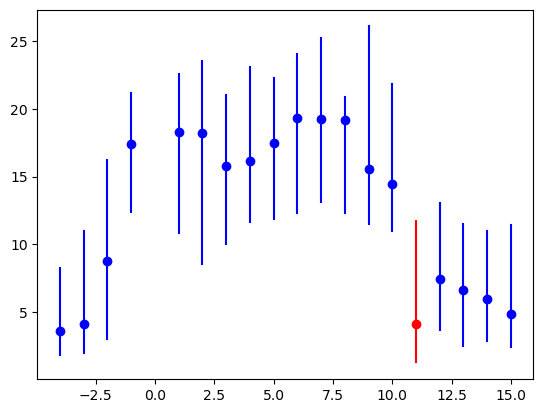

In [1123]:

for dd in [-1,-2,-3,-4]:
    
    cond = ((df.day_before_event == dd) & (df['2003_2023'] == True)) #& (df['final_day'] == False)

    s10 = np.sqrt(df.u10[cond]**2 + df.v10[cond]**2)
    si = np.sqrt(df.ui[cond]**2 + df.vi[cond]**2)
    
#     plt.scatter(dd, np.nanmedian(s10), c='b')
#     plt.plot([dd,dd], [np.nanpercentile(s10, 25),np.nanpercentile(s10, 75)], c='b')

    plt.scatter(dd, np.nanmedian(si), c='b')
    plt.plot([dd,dd], [np.nanpercentile(si, 25),np.nanpercentile(si, 75)], c='b')
    
    
for dd in [1,2,3,4,5,6,7,8,9,10]:
    
    cond = ((df.event_day == dd) & (df['2003_2023'] == True)) #& (df['event_length'] == 1)

    s10 = np.sqrt(df.u10[cond]**2 + df.v10[cond]**2)
    si = np.sqrt(df.ui[cond]**2 + df.vi[cond]**2)
    
#     plt.scatter(dd, np.nanmedian(s10), c='b')
#     plt.plot([dd,dd], [np.nanpercentile(s10, 25),np.nanpercentile(s10, 75)], c='b')

    plt.scatter(dd, np.nanmedian(si), c='b')
    plt.plot([dd,dd], [np.nanpercentile(si, 25),np.nanpercentile(si, 75)], c='b')
    
DD = dd

for dd in [DD+1]:
    
    cond = (df['2003_2023'] == True) & (df['final_day'] == False)

    s10 = np.sqrt(df.u10[cond]**2 + df.v10[cond]**2)
    si = np.sqrt(df.ui[cond]**2 + df.vi[cond]**2)
    
#     plt.scatter(dd, np.nanmedian(s10), c='r')
#     plt.plot([dd,dd], [np.nanpercentile(s10, 25),np.nanpercentile(s10, 75)], c='r')

    plt.scatter(dd, np.nanmedian(si), c='r')
    plt.plot([dd,dd], [np.nanpercentile(si, 25),np.nanpercentile(si, 75)], c='r')


for dd in [1,2,3,4]:
    
    cond = ((df.day_after_event == dd) & (df['2003_2023'] == True)) #& (df['final_day'] == False)

    s10 = np.sqrt(df.u10[cond]**2 + df.v10[cond]**2)
    si = np.sqrt(df.ui[cond]**2 + df.vi[cond]**2)
    
#     plt.scatter(DD+1+dd, np.nanmedian(s10), c='b')
#     plt.plot([DD+1+dd,DD+1+dd], [np.nanpercentile(s10, 25),np.nanpercentile(s10, 75)], c='b')

    plt.scatter(DD+1+dd, np.nanmedian(si), c='b')
    plt.plot([DD+1+dd,DD+1+dd], [np.nanpercentile(si, 25),np.nanpercentile(si, 75)], c='b')
    

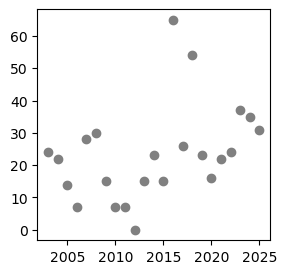

In [980]:
fig, ax = plt.subplots(figsize=(3,3))

years = np.arange(2003,2026)

for yy, year in enumerate(years):

    
#     cond = ((df.extent > 0) & (df.month==month)) & (df.year <= 2023)

    cond = ((df.extent > 0)) & ((df.year == year))
    
    
    plt.scatter(year, np.sum(cond), c='gray')
    
    
#     month_cond = cond & ((df.month==4))
    
#     plt.scatter(year, np.sum(month_cond), c='k')

In [ ]:
/np.sum(cond)

In [922]:
df.month==12

0        True
1        True
2        True
3        True
4        True
        ...  
5743    False
5744    False
5745    False
5746    False
5747    False
Name: month, Length: 5748, dtype: bool

In [80]:
years = np.arange(2003,2026)

all_max_dirs = np.array([])
all_com_dirs = np.array([])

all_max_lens_og = np.array([])
all_max_lens_new = np.array([])
all_145_lens_new = np.array([])

for year in years:
    
#     with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc') as ds:

#         time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
#         ds = ds.sel(time = time_range)

#         non_nan = ds.polynya_extent > 0
        
#         all_max_lens_og = np.append(all_max_lens_og, ds.max_length.values[non_nan])

    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.2_radius25km.nc') as ds:

        time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
        ds = ds.sel(time = time_range)

        non_nan = ds.polynya_extent > 0

        all_max_dirs = np.append(all_max_dirs, ds.max_length_direction.values[non_nan])
        all_com_dirs = np.append(all_com_dirs, ds.com_direction.values[non_nan])
        all_max_lens_new = np.append(all_max_lens_new, ds.max_length.values[non_nan])
        all_145_lens_new = np.append(all_145_lens_new, ds.l_max.values[non_nan])


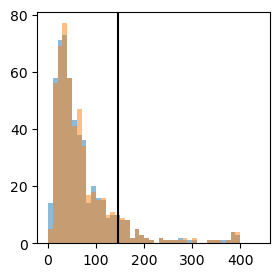

In [81]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(all_145_lens_new, bins=np.arange(0,450,10), alpha=0.5);
ax.hist(all_max_lens_new, bins=np.arange(0,450,10), alpha=0.5);
plt.axvline(145, c='k')

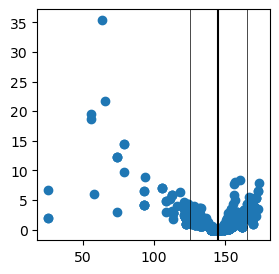

In [112]:
fig, ax = plt.subplots(figsize=(3,3))

dl = all_max_lens_new - all_145_lens_new

ax.scatter(all_max_dirs, dl)
plt.axvline(145, c='k')
plt.axvline(145-da, c='k', lw=0.5)
plt.axvline(145+da, c='k', lw=0.5)


11
18
11
28
30
77
62
94
54
54
29
35


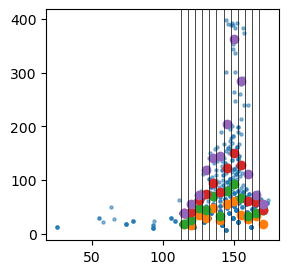

In [196]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(all_max_dirs, all_max_lens_new, s=5, alpha=0.5)


dir_bins = np.arange(112.5,180-5,5)
bin_centers = dir_bins[:-1] + np.diff(dir_bins)[0]/2

lens_per100 = []
lens_per95 = []
lens_per75 = []
lens_per50 = []
lens_per25 = []
lens_per5 = []

for dd in range(len(dir_bins)-1):
    
    bmin = dir_bins[dd]
    bmax = dir_bins[dd+1]
    
    within_bin = (all_max_dirs >= bmin) & (all_max_dirs < bmax)
    
    lens_per100.append( np.nanpercentile(all_max_lens_new[within_bin], 100))
    lens_per95.append( np.nanpercentile(all_max_lens_new[within_bin], 95))
    lens_per75.append( np.nanpercentile(all_max_lens_new[within_bin], 75))
    lens_per50.append( np.nanpercentile(all_max_lens_new[within_bin], 50))
    lens_per25.append( np.nanpercentile(all_max_lens_new[within_bin], 25))
    lens_per5.append( np.nanpercentile(all_max_lens_new[within_bin], 5))
    
    plt.axvline(bmin, lw=0.5, c='k')
    
    print(np.sum(within_bin))

ax.scatter(bin_centers, lens_per25)
ax.scatter(bin_centers, lens_per50)
ax.scatter(bin_centers, lens_per75)
ax.scatter(bin_centers, lens_per95)
# plt.axvline(145, c='k')
# plt.axvline(145-da, c='k', lw=0.5)
# plt.axvline(145+da, c='k', lw=0.5)


lens_per100 = np.array(lens_per100)
lens_per95 = np.array(lens_per95)
lens_per75 = np.array(lens_per75)
lens_per50 = np.array(lens_per50)
lens_per25 = np.array(lens_per25)
lens_per5 = np.array(lens_per5)


In [197]:
bin_centers[np.isfinite(lens_per95)]

array([115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170.])

In [200]:
lens_per95[np.isfinite(lens_per95)]

array([ 38.25523663,  55.51080706,  71.71114602, 119.51984847,
       141.88020872, 144.86527646, 203.61409144, 363.14614689,
       284.88229401, 111.02230219,  72.498526  ,  55.10222014])

In [188]:
lens_per95

array([ 30.40655457,  48.30208459,  24.61383942,          nan,
        21.866872  ,  30.58498803,  61.77205835,  75.11826304,
       145.35498174, 201.4419877 , 285.66913496,  72.84055227])

In [156]:
bin_centers

array([107.5, 112.5, 117.5, 122.5, 127.5, 132.5, 137.5, 142.5, 147.5,
       152.5, 157.5, 162.5, 167.5, 172.5])

In [155]:
lens_per95

[30.584988031740743,
 51.11467969535947,
 58.908629651949006,
 63.12707850675092,
 80.29521352325666,
 134.3634552745552,
 152.20240503942873,
 149.5562903353531,
 351.5870708369046,
 283.05762040664996,
 283.96168867673595,
 74.77870113587366,
 71.71484663505953,
 61.1090685573536]

In [145]:
bin_centers

array([ 95., 105., 115., 125., 135., 145., 155., 165., 175.])

In [127]:
len(all_max_dirs)

536

In [111]:
np.sum(dl < 10)/len(dl)

0.9832089552238806

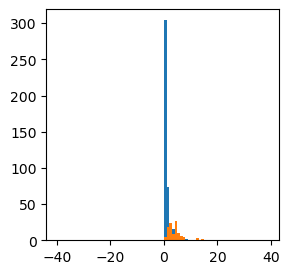

In [109]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(dl[angle_cond], bins=np.arange(-40,40,1));
ax.hist(dl[angle_cond==False], bins=np.arange(-40,40,1));

In [86]:
np.nanmedian(all_com_dirs)

143.61037967161934

In [98]:
da = 20

angle_cond = (all_max_dirs>145-da)&(all_max_dirs<145+da)

np.sum(angle_cond)/len(all_max_dirs)

0.7873134328358209

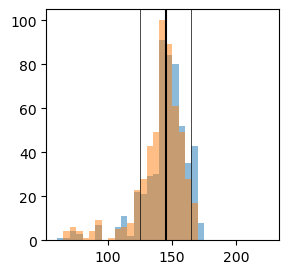

In [95]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(all_max_dirs, bins=np.arange(60,230,5), alpha=0.5);
ax.hist(all_com_dirs, bins=np.arange(60,230,5), alpha=0.5);
plt.axvline(145, c='k')
plt.axvline(145-da, c='k', lw=0.5)
plt.axvline(145+da, c='k', lw=0.5)



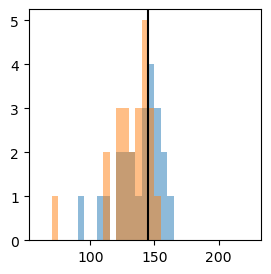

In [8]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(ds.max_length_direction.values, bins=np.arange(60,230,5), alpha=0.5);
ax.hist(ds.com_direction.values, bins=np.arange(60,230,5), alpha=0.5);
plt.axvline(145, c='k')


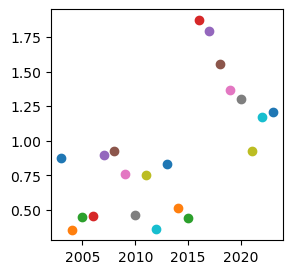

In [66]:
fig, ax = plt.subplots(figsize=(3,3))

for year in np.arange(2003,2026):
    
#     if year!=2012:
    
#         onedayev = np.sum((df.year == year) & (df.event_length <= 1))

#         multdayev = np.sum((df.year == year) & (df.event_length > 1))

#     #     ax.scatter(year, onedayev, c='gray')

#         ax.scatter(year, multdayev / (onedayev + multdayev))


    wa = vectors.vector_angle(df.u10.values, df.v10.values).magnitude
    
    dir_cond = (wa > 145) + (wa < -170)


    cond = ((df.s10 > 3)&(dir_cond)) & (df.year == year)


#     cond = ((df.si > 15)&(dir_cond)) & (df.year == year)
    
    s10 = np.sqrt(df.u10[cond].values**2 + df.v10[cond].values**2)
    si = np.sqrt(df.ui[cond].values**2 + df.vi[cond].values**2)
    
#     plt.scatter(year, np.nanmean(s10))
#     plt.scatter(year, np.nanmedian(s10), c='k')
    
    plt.scatter(year, np.nanpercentile((si/s10), 25))

#     ax.scatter(year, np.sum(cond))
    
# plt.ylim(-0.1,1)


In [19]:
df.event_length

0      -999
1      -999
2      -999
3      -999
4      -999
       ... 
5743   -999
5744   -999
5745   -999
5746   -999
5747   -999
Name: event_length, Length: 5748, dtype: int64